In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import openslide
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
from tensorflow.keras import layers, models, applications
from PIL import Image
from sklearn.utils import compute_class_weight
from tqdm.notebook import trange, tqdm

In [38]:
################################ FUNCTION ###############################

def convertIntoRGB(level=2):
    for i in trange(len(image_id)):
        if os.path.isfile(masks_path + mask_id[i]) == True:
            im = openslide.OpenSlide(masks_path + mask_id[i])
            im2 = im.read_region(location=(0, 0), level=level, \
                                  size=(im.level_dimensions[level][0],\
                                        im.level_dimensions[level][1]))
            im.close()
            mask_data = np.asarray(im2)[:, :, 0:3]
            new_mask_data = np.array(mask_data)
            
            if image_info[i][0] == 'radboud':
                new_mask_data[np.where((mask_data == [1, 0, 0]).all(axis=2))] = [127, 127, 127]
                new_mask_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [0, 255, 0]
                new_mask_data[np.where((mask_data == [3, 0, 0]).all(axis=2))] = [255, 255, 0]
                new_mask_data[np.where((mask_data == [4, 0, 0]).all(axis=2))] = [255, 165, 0]
                new_mask_data[np.where((mask_data == [5, 0, 0]).all(axis=2))] = [255, 0, 0]
            else:
                new_mask_data[np.where((mask_data == [1, 0, 0]).all(axis=2))] = [127, 127, 127]
                new_mask_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [255, 0, 0]
                
            im = Image.fromarray(new_mask_data)
            im.save("./prostate-cancer-grade-assessment/new_train_label_masks/" + mask_id[i])
            
def visualizePixels():
    pixel_x = []
    pixel_y = []
    pixel_x_rad = []
    pixel_y_rad = []
    pixel_x_kar = []
    pixel_y_kar = []
    for i in trange(len(image_id)):
        im = openslide.OpenSlide(images_path + image_id[i])
        pixel_y.append(im.level_dimensions[-1][0])
        pixel_x.append(im.level_dimensions[-1][1])
        if image_info[i][0] == 'karolinska':
            pixel_y_kar.append(im.level_dimensions[-1][0])
            pixel_x_kar.append(im.level_dimensions[-1][1])
        else:
            pixel_y_rad.append(im.level_dimensions[-1][0])
            pixel_x_rad.append(im.level_dimensions[-1][1])
        im.close()
        
    print(np.mean(pixel_x), np.mean(pixel_y))
    plt.plot(pixel_x_rad, pixel_y_rad, 'r.')
    plt.plot(pixel_x_kar, pixel_y_kar, 'b.')
    plt.grid()
    plt.show()

def visualizeTiles(data, sz, ifMask=False):
    tiles = tile(data, sz)
    if ifMask:
        tiles.sort(key = lambda x: x.sum(), reverse=True) 
    else:
        tiles.sort(key = lambda x: x.sum()) 
    print("# tiles:", len(tiles))

    if len(tiles) >= 25:
        length = 5
    else:
        length = len(tiles) // 5

    for n in range(length):
        fig, ax = plt.subplots(1, 5, figsize=(10, 10))
        for i in range(5):
            if ifMask:
                if image_info[idx][0] == 'karolinska':
                    ax[i].imshow(tiles[5 * n + i][:, :, 0], cmap=cmap2, vmin=0, vmax=2, interpolation='nearest')
                else:
                    ax[i].imshow(tiles[5 * n + i][:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
            else:
                ax[i].imshow(tiles[5 * n + i])
            ax[i].axis('off')
        plt.tight_layout()
        plt.show()
            
def visualizeOverlay(im_data, mask_data):
    new_data = np.array(im_data)
    if image_info[idx][0] == 'karolinska':
        new_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [255, 0, 0]
    else:
        new_data[np.where((mask_data == [2, 0, 0]).all(axis=2))] = [0, 255, 0]
        new_data[np.where((mask_data == [3, 0, 0]).all(axis=2))] = [255, 255, 0]
        new_data[np.where((mask_data == [4, 0, 0]).all(axis=2))] = [255, 165, 0]
        new_data[np.where((mask_data == [5, 0, 0]).all(axis=2))] = [255, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(new_data)
    if image_info[idx][0] == 'karolinska':
        ax[1].imshow(mask_data[:, :, 0], cmap=cmap2, vmin=0, vmax=2, interpolation='nearest')
    else:
        ax[1].imshow(mask_data[:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
    plt.show()

def tile(data, sz):
    tiles = []
    for row_idx in range(len(data) // sz):
        for col_idx in range(len(data[0]) // sz):
            tiles.append(data[row_idx*sz:(row_idx*sz+sz)][:, col_idx*sz:(col_idx*sz + sz)])
    return tiles
    
def tile2(data, sz):
    tiles = {}
    count = 0
    for row_idx in range(len(data) // sz):
        for col_idx in range(len(data[0]) // sz):
            tiles[count] = data[row_idx*sz:(row_idx*sz+sz)][:, col_idx*sz:(col_idx*sz + sz)]
            count += 1
    return tiles

def grade(tile):
    score = []
    relative_score = []
    tissue_count = 1
    for i in range(1, 6):
        count = 0
        for row in tile:
            comparsion = row == [i, 0, 0]
            count += comparsion.all(axis=1).sum()
        score.append(count / (len(tile) ** 2))
        if i == 1:
            if count > 0:
                tissue_count = count
            else:
                tissue_count = 1
        else:
            relative_score.append(count / tissue_count)
    return score, relative_score

def if_clean(tile):
    for row in tile:
        comparsion = row == [0, 0, 0]
        if comparsion.all(axis=1).sum() > 0:
            return False
    return True

def unsharp_masking(img):
    """ Unsharp masking of an RGB image"""
    img_gaussian = cv2.GaussianBlur(img, (21,21), 10.0)
    return cv2.addWeighted(img, 1.8, img_gaussian, -0.8, 0, img)

def N_tiles(level=2, sz=128):
    N_tiles_array = []
    
    for i in trange(len(image_id)):
        # Read image
        im = openslide.OpenSlide(images_path + image_id[i])
        im2 = im.read_region(location=(0, 0), level=level, \
                          size=(im.level_dimensions[level][0],\
                                im.level_dimensions[level][1]))
        im.close()
        data = np.asarray(im2)[:, :, 0:3]
        
        # Split into tiles
        tiles = tile(data, sz)
        
        N_tiles_array.append(len(tiles))
    return N_tiles_array

def split_into_traintest(level=2):
    
    good_image_id = []
    good_mask_id = []
    good_image_info = []
    bad_image_id = []
    bad_mask_id = []
    bad_image_info = []
    
    for i in trange(len(image_id)):
#     for i in trange(51):
        # Check if masks exist
        if os.path.isfile(masks_path + mask_id[i]):
            ifBad = 0
            # Check if provider is radboud
            if image_info[i][0] == 'radboud':
                # Read mask
                im = openslide.OpenSlide(masks_path + mask_id[i])
                im2 = im.read_region(location=(0, 0), level=level, \
                                      size=(im.level_dimensions[level][0],\
                                            im.level_dimensions[level][1]))
                im.close()
                mask_data = np.asarray(im2)[:, :, 0:3]

                # Count pixels
                score, relative_score = grade(mask_data)
                
                # Check if ISUP grade > 0
                if int(image_info[i][1]) > 0:
                    # Find Gleason score
                    first_score = int(image_info[i][2][0])

                    if (np.argmax(relative_score) + 2) == first_score:
                        ifBad = 0
                    else:
                        ifBad = 1
                else:
                    if (np.argmax(score) + 1) <= 2:
                        ifBad = 0
                    else:
                        ifBad = 1
            else:
                ifBad = 1
        else:
            ifBad = 1
            
        if ifBad:
            bad_image_id.append(image_id[i])
            bad_mask_id.append(mask_id[i])
            bad_image_info.append(image_info[i])
        else:
            good_image_id.append(image_id[i])
            good_mask_id.append(mask_id[i])
            good_image_info.append(image_info[i])
        
    return np.array([good_image_id]).T, np.array([good_mask_id]).T, \
            np.array([good_image_info])[0], np.array([bad_image_id]).T, \
            np.array([bad_mask_id]).T, np.array([bad_image_info])[0]

def create_patches(img_id, msk_id, level=1, sz=224, ifSharp=False): 
    patches = []
    
    for i in trange(len(img_id)):
#     for i in trange(2, 3):
        # Read image
        im = openslide.OpenSlide(images_path + img_id[i])
        im2 = im.read_region(location=(0, 0), level=level, \
                          size=(im.level_dimensions[level][0],\
                                im.level_dimensions[level][1]))
        im.close()
        data = np.asarray(im2)[:, :, 0:3]
        
        # Read masks
        im = openslide.OpenSlide(masks_path + msk_id[i])
        im2 = im.read_region(location=(0, 0), level=level, \
                              size=(im.level_dimensions[level][0],\
                                    im.level_dimensions[level][1]))
        im.close()
        mask_data = np.asarray(im2)[:, :, 0:3]

#         # Clean data
#         clean_data = np.array(data)
#         clean_data[np.where((mask_data == [0, 0, 0]).all(axis=2))] = [255, 255, 255]

        # Split image and mask into tiles
        tiles1 = tile2(data, sz)
        tiles2 = tile2(mask_data, sz)

        if len(tiles1) > 0:
            # Rank image tiles by counting color pixels
            tiles2 = {k: v for k, v in sorted(tiles2.items(), key=lambda item: item[1].sum(), reverse=True)}
            
            iteration = 0
            # Score mask tiles
            for tile_idx in tiles2.keys():
                score, relative_score = grade(tiles2[tile_idx])
                
                # Find pattern
                tile_score = -1
                if np.sum(score) == 1:
                    if np.sort(relative_score)[:3].sum() == 0:
                        if score[np.argmax(relative_score) + 1] > 0.4:
                            tile_score = np.argmax(relative_score) + 2
                        elif score[0] > 0.4:
                            tile_score = 1

                if tile_score >= 1:
                    if if_clean(tiles1[tile_idx]):
                        if ifSharp:
                            im = Image.fromarray(unsharp_masking(tiles1[tile_idx]))
                            temp = "./prostate-cancer-grade-assessment/patches_level1_" + str(sz) + \
                                    "_clean/" + str(tile_score) + "/" + img_id[i].split(".")[0] + \
                                    "/"
                        else:
                            im = Image.fromarray(tiles1[tile_idx])
                            temp = "./prostate-cancer-grade-assessment/patches_level1_" + str(sz) + \
                                    "/" + str(tile_score) + "/" + img_id[i].split(".")[0] + \
                                    "/"
                        if not os.path.isdir(temp):
                            os.mkdir(temp)
                        
                        im.save(temp + str(iteration) + img_id[i])
                        patches.append([str(iteration) + img_id[i], str(tile_score)])

                iteration += 1
                if iteration > 5:
                    break
    if ifSharp:
        np.savetxt("./prostate-cancer-grade-assessment/patches_level1_" + str(sz) + "_clean.csv", \
                   patches, delimiter=",", fmt="%s")
    else:
        np.savetxt("./prostate-cancer-grade-assessment/patches_level1_" + str(sz) + ".csv", \
                   patches, delimiter=",", fmt="%s")

def create_patches_deepZoom(img_id, msk_id, sz=224, level=14):
#     for i in trange(len(img_id)):
    for i in trange(2):
        # Read image & mask
        im1 = openslide.OpenSlide(images_path + img_id[i])
        img_deepZoom = openslide.deepzoom.DeepZoomGenerator(im1, sz, 0, True)
        
        im2 = openslide.OpenSlide(masks_path + msk_id[i])
        msk_deepZoom = openslide.deepzoom.DeepZoomGenerator(im2, sz, 0, True)
        col, row = img_deepZoom.level_tiles[level]
        
        # Extract tiles
        tiles1 = {}
        tiles2 = {}
        count = 0
        for row_idx in range(row):
            for col_idx in range(col):
                img_tile = img_deepZoom.get_tile(level, (col_idx, row_idx))
                msk_tile = msk_deepZoom.get_tile(level, (col_idx, row_idx))
                img_data = np.asarray(img_tile)[:, :, 0:3]
                msk_data = np.asarray(msk_tile)[:, :, 0:3]
                
                # Clean data
                clean_data = np.array(img_data)
                clean_data[np.where((msk_data == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
                
                # Append tiles
                tiles1[count] = clean_data
                tiles2[count] = msk_data
                count += 1
        im1.close()
        im2.close()

        if len(tiles1) > 0:
            # Rank image tiles by counting color pixels
            tiles2 = {k: v for k, v in sorted(tiles2.items(), key=lambda item: item[1].sum(), reverse=True)}
            
            iteration = 0
            # Score mask tiles
            for tile_idx in tiles2.keys():
                score, relative_score = grade(tiles2[tile_idx])

                # Find pattern
                tile_score = -1
                if np.sum(score) == 1:
                    if np.sort(relative_score)[:3].sum() == 0:
                        if score[np.argmax(relative_score) + 1] > 0.4:
                            tile_score = np.argmax(relative_score) + 2
                        elif score[0] > 0.4:
                            tile_score = 1

                if tile_score >= 1:
                    im = Image.fromarray(tiles1[tile_idx])
                    im.save("./prostate-cancer-grade-assessment/patches_level14/" + \
                            str(tile_score) + "/" + str(iteration) + img_id[i])
                    
                iteration += 1
                if iteration > 5:
                    break

In [31]:
################################## GLOBAL ###############################

new_train_info_path = "./prostate-cancer-grade-assessment/new_train.csv"
new_test_info_path = "./prostate-cancer-grade-assessment/new_test.csv"
info_path = "./prostate-cancer-grade-assessment/train.csv"
images_path = "./prostate-cancer-grade-assessment/train_images/"
masks_path = "./prostate-cancer-grade-assessment/train_label_masks/"

image_format = ".tiff"
mask_format = "_mask.tiff"

image_id = np.genfromtxt(info_path, delimiter=",", dtype='str',\
                         skip_header=1, usecols=0)
mask_id = np.char.add(image_id, mask_format)
image_id = np.char.add(image_id, image_format)

image_info = np.genfromtxt(info_path, delimiter=",", dtype='str',\
                         skip_header=1, usecols=(1,2,3))

cmap1 = mpl.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
cmap2 = mpl.colors.ListedColormap(['black', 'gray', 'red'])

train_image_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=0)
train_mask_id = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=1)
train_image_info = np.genfromtxt(new_train_info_path, delimiter=",", dtype='str', usecols=(2,3,4))
test_image_id = np.genfromtxt(new_test_info_path, delimiter=",", dtype='str', usecols=0)
test_mask_id = np.genfromtxt(new_test_info_path, delimiter=",", dtype='str', usecols=1)
test_image_info = np.genfromtxt(new_test_info_path, delimiter=",", dtype='str', usecols=(2,3,4))

In [ ]:
# convertIntoRGB()


1440.4184096476351 1180.8391746749576


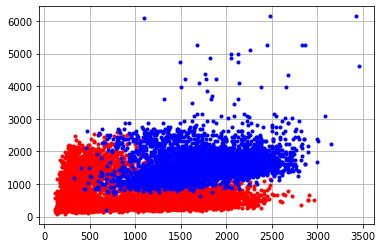

In [4]:
visualizePixels()

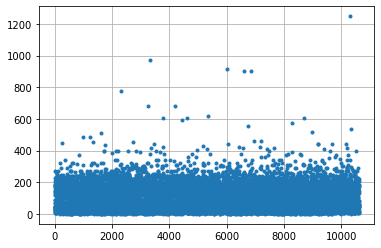

In [5]:
N_tiles_array = N_tiles()

plt.plot(list(range(len(N_tiles_array))), N_tiles_array, '.')
plt.grid()
plt.show()

In [ ]:
idx = 68
level = 1


fig, ax = plt.subplots(1, 3, figsize=(10, 10))
im = openslide.OpenSlide(images_path + image_id[idx])

print(im.level_dimensions)
print(image_info[idx])
im2 = im.read_region(location=(0, 0), level=level, \
                      size=(im.level_dimensions[level][0],\
                            im.level_dimensions[level][1]))
data = np.asarray(im2)[:, :, 0:3]
ax[0].imshow(data)
im.close()


im = openslide.OpenSlide(masks_path + mask_id[idx])
im2 = im.read_region(location=(0, 0), level=level, \
                      size=(im.level_dimensions[level][0],\
                            im.level_dimensions[level][1]))
im.close()
mask_data = np.asarray(im2)[:, :, 0:3]

score, relative_score = grade(mask_data)
print(score, relative_score)

if image_info[idx][0] == 'karolinska':
    ax[1].imshow(mask_data[:, :, 0], cmap=cmap2, vmin=0, vmax=2, interpolation='nearest')
else:
    ax[1].imshow(mask_data[:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
    
    
clean_data = np.array(data)
clean_data[np.where((mask_data == [0, 0, 0]).all(axis=2))] = [255, 255, 255]
ax[2].imshow(clean_data)


plt.show()

hist_data = np.concatenate((clean_data[:, :, 0].flatten(), clean_data[:, :, 1].flatten(), clean_data[:, :, 2].flatten()))
plt.hist(clean_data[:, :, 0].flatten(), density=True, color='red')
plt.hist(clean_data[:, :, 1].flatten(), density=True, color='green')
plt.hist(clean_data[:, :, 2].flatten(), density=True, color='blue')
plt.grid()
plt.show()

# tiles: 64


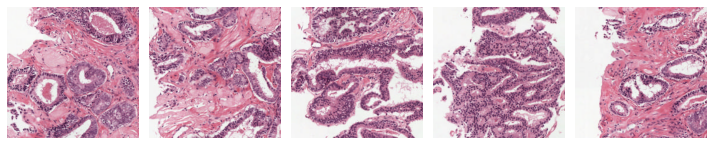

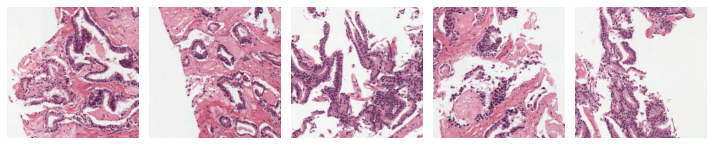

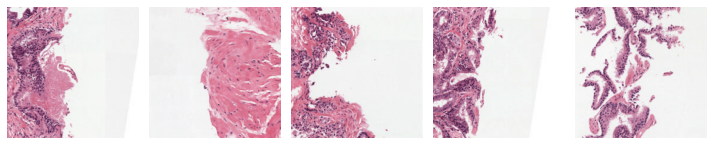

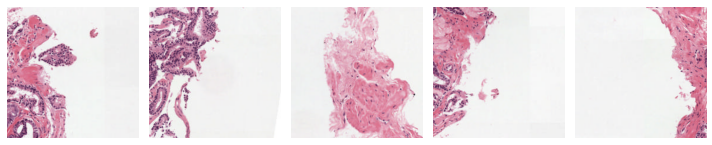

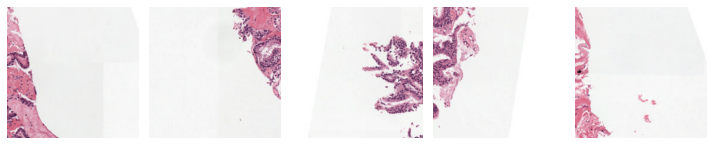

# tiles: 64


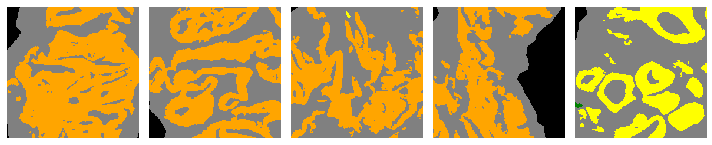

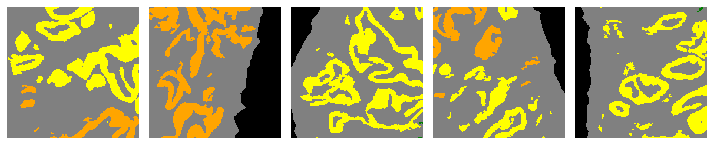

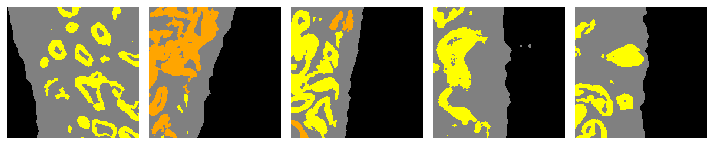

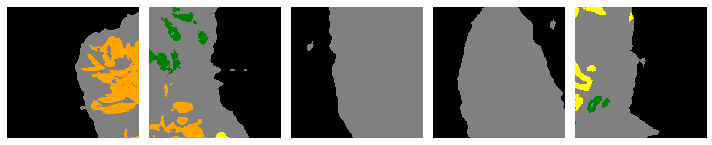

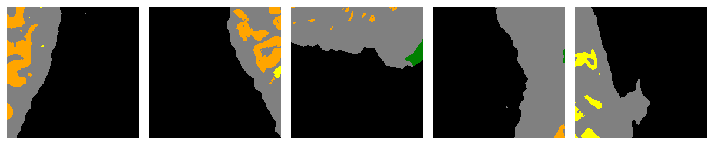

In [28]:
# visualizeTiles(clean_data, 128)
visualizeTiles(data, 224)
visualizeTiles(mask_data, 224, ifMask=True)
# visualizeOverlay(clean_data, mask_data)

In [18]:
tiles1 = tile2(clean_data, 128)
tiles2 = tile2(mask_data, 128)
tiles2 = {k: v for k, v in sorted(tiles2.items(), key=lambda item: item[1].sum(), reverse=True)}
print(tiles2.keys())

dict_keys([49, 50, 29, 38, 26, 62, 28, 39, 41, 65, 40, 52, 55, 61, 42, 27, 57, 56, 14, 43, 53, 30, 63, 51, 64, 54, 44, 16, 66, 37, 31, 15, 17, 74, 75, 67, 25, 45, 73, 76, 32, 68, 58, 69, 77, 13, 48, 18, 46, 19, 60, 78, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 21, 22, 23, 24, 33, 34, 35, 36, 47, 59, 70, 71, 72, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])


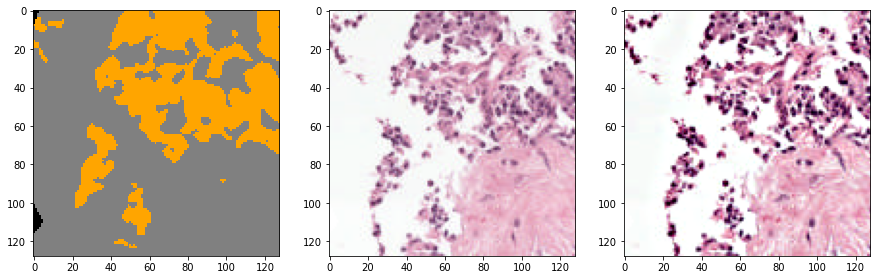

[0.70355224609375, 0.0, 0.0, 0.2928466796875, 0.0]
[0.0, 0.0, 0.4162401318643186, 0.0]
0.99639892578125
0.0
-1


In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

tile_idx = 49
test = np.array(tiles2[tile_idx])
ax[0].imshow(test[:, :, 0], cmap=cmap1, vmin=0, vmax=5, interpolation='nearest')
ax[1].imshow(tiles1[tile_idx])
ax[2].imshow(unsharp_masking(tiles1[tile_idx]))
plt.show()

score, relative_score = grade(test)

print(score)
print(relative_score)
print(np.sum(score))
print(np.sort(relative_score)[:3].sum())

tile_score = -1
if np.sum(score) == 1:
    if np.sort(relative_score)[:3].sum() == 0:
        if score[np.argmax(relative_score) + 1] > 0.4:
            tile_score = np.argmax(relative_score) + 2
print(tile_score)

In [96]:
# train_image_id, train_mask_id, train_image_info, test_image_id, test_mask_id, test_image_info = split_into_traintest()

# temp1 = np.concatenate((train_image_id, train_mask_id, train_image_info), axis=1)
# temp2 = np.concatenate((test_image_id, test_mask_id, test_image_info), axis=1)
# print(len(temp1), len(temp2))
# np.savetxt("./prostate-cancer-grade-assessment/new_train.csv", temp1, delimiter=",", fmt="%s")
# np.savetxt("./prostate-cancer-grade-assessment/new_test.csv", temp2, delimiter=",", fmt="%s")


3672 6942


In [97]:
# new_train = np.genfromtxt("./prostate-cancer-grade-assessment/new_train.csv", delimiter=",", dtype='str')
# suspicious_train = np.genfromtxt("./prostate-cancer-grade-assessment/suspicious_train.csv", delimiter=",", dtype='str')
# print(new_train[0])
# print(suspicious_train[0])

# temp = []
# for idx1 in trange(len(new_train)):
# # for idx1 in trange(500):
#     check = 0
#     for idx2 in range(len(suspicious_train)):
#         if suspicious_train[idx2] in new_train[idx1][0]:
#             check = 1
#             break
#     if check == 0:
#         temp.append(new_train[idx1])
        
# print(len(new_train), len(temp))
# np.savetxt("./prostate-cancer-grade-assessment/temp.csv", temp, delimiter=",", fmt="%s")

['0018ae58b01bdadc8e347995b69f99aa.tiff'
 '0018ae58b01bdadc8e347995b69f99aa_mask.tiff' 'radboud' '4' '4+4']
184a184ac82d72d499f99b67d6a1c631



3672 3347


In [39]:
create_patches(train_image_id, train_mask_id, sz=224, ifSharp=True)

TypeError: Expected Ptr<cv::UMat> for argument 'dst'

In [161]:
# patches_info_path = "./prostate-cancer-grade-assessment/patches_level1_128_clean.csv"
# patches_path = "./prostate-cancer-grade-assessment/patches_level1_128_clean/"

# patches_id = np.genfromtxt(patches_info_path, delimiter=",", dtype='str', usecols=0)
# patches_info = np.genfromtxt(patches_info_path, delimiter=",", dtype='str', usecols=1)

# for idx in trange(len(patches_id)):
#     label = patches_id[idx][:1]
#     folder = patches_id[idx][1:].split(".tiff")[0]
    
#     img = Image.open(patches_path + patches_info[idx] + "/" + folder + "/" + patches_id[idx])
#     img_data = np.asarray(img)
#     im = Image.fromarray(unsharp_masking(img_data))
#     im.save(patches_path + patches_info[idx] + "/" + folder + "/" + patches_id[idx])